# Prompt
This assignment concerns natural language processing. You are asked to create deep neural networks for language processing and to analyze how various factors affect the fitting and ultimate test set performance of these networks.

A useful exercise is to compare processing requirements and predictive accuracy of dense versus recurrent neural networks with long short-term memory.

# Data Preparation

In [1]:
# import standard packages here
# non standard packages are imported closer to the code/functions that use them
import warnings
warnings.filterwarnings("ignore")
import gc # Garbage Collector
import keras.backend as K

# import data manipulation/visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for model building and results
import tensorflow as tf
from keras.models import load_model, Sequential
from keras.layers import Embedding, LSTM, Flatten, Dense, SimpleRNN, Dropout

# misc
import pickle
import time
from prettytable import PrettyTable

# fix a random seed for reproducibility
RANDOM_SEED = 42
from numpy.random import seed
from tensorflow import set_random_seed
def reset_graph(seed = RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Using TensorFlow backend.


In [2]:
# set working directory
import os
os.getcwd()

# set other file paths vars
data_path = '..\\data'
model_path = '..\\output\\models'

# define color palette
current_palette = sns.color_palette() #10 colors

In [3]:
# using the reduced reuters corpus, which is contained in json files
# need to read in the files line by line giving error just using json.load
import json

train_data = []
with open(os.path.join(data_path,'reuters_train.jl')) as f:
    for line in f:
        train_data.append(json.loads(line))
        
test_data = []
with open(os.path.join(data_path,'reuters_test.jl')) as f:
    for line in f:
        test_data.append(json.loads(line))

In [4]:
# perform some quick inspections
train_data[0]
# we really just need to extract the category and text data

{'corpus': 'reuters',
 'dataset': 'train',
 'filename': 'training/10',
 'category': 'acq',
 'text': "COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES SALE\n  Computer Terminal Systems Inc said\n  it has completed the sale of 200,000 shares of its common\n  stock, and warrants to acquire an additional one mln shares, to\n  &lt;Sedio N.V.> of Lugano, Switzerland for 50,000 dlrs.\n      The company said the warrants are exercisable for five\n  years at a purchase price of .125 dlrs per share.\n      Computer Terminal said Sedio also has the right to buy\n  additional shares and increase its total holdings up to 40 pct\n  of the Computer Terminal's outstanding common stock under\n  certain circumstances involving change of control at the\n  company.\n      The company said if the conditions occur the warrants would\n  be exercisable at a price equal to 75 pct of its common stock's\n  market price at the time, not to exceed 1.50 dlrs per share.\n      Computer Terminal also said it sold the te

In [65]:
print("Length of training data: ", len(train_data))
print("Lenght of test data: ", len(test_data))

Length of training data:  5583
Lenght of test data:  2208


In [66]:
print(train_data[0]['category'])
print(test_data[0]['category'])

acq
trade


In [67]:
test_data[0]

{'corpus': 'reuters',
 'dataset': 'test',
 'filename': 'test/14826',
 'category': 'trade',
 'text': 'ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT\n  Mounting trade friction between the\n  U.S. And Japan has raised fears among many of Asia\'s exporting\n  nations that the row could inflict far-reaching economic\n  damage, businessmen and officials said.\n      They told Reuter correspondents in Asian capitals a U.S.\n  Move against Japan might boost protectionist sentiment in the\n  U.S. And lead to curbs on American imports of their products.\n      But some exporters said that while the conflict would hurt\n  them in the long-run, in the short-term Tokyo\'s loss might be\n  their gain.\n      The U.S. Has said it will impose 300 mln dlrs of tariffs on\n  imports of Japanese electronics goods on April 17, in\n  retaliation for Japan\'s alleged failure to stick to a pact not\n  to sell semiconductors on world markets at below cost.\n      Unofficial Japanese estimates put the impact

In [84]:
# split up our train and test sets by grabbing the text and category values
X_train = []
y_train = []
for i in range(len(train_data)):
    X_train.append(train_data[i]['text'])
    y_train.append(train_data[i]['category'])

X_test = []
y_test = []
for i in range(len(test_data)):
    X_test.append(test_data[i]['text'])
    y_test.append(test_data[i]['category'])

In [85]:
# validate this manipulation was done properly
print("X_train[0]: ", X_train[0])
print("y_train[0]: ", y_train[0])
print("Unique y_train values: ", np.unique(y_train))
print("X_test[0]: ", X_test[0])
print("y_test[0]: ", y_test[0])
print("Unique y_test values: ", np.unique(y_test))
# see the same unique y_train & y_test values which is good

X_train[0]:  COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES SALE
  Computer Terminal Systems Inc said
  it has completed the sale of 200,000 shares of its common
  stock, and warrants to acquire an additional one mln shares, to
  &lt;Sedio N.V.> of Lugano, Switzerland for 50,000 dlrs.
      The company said the warrants are exercisable for five
  years at a purchase price of .125 dlrs per share.
      Computer Terminal said Sedio also has the right to buy
  additional shares and increase its total holdings up to 40 pct
  of the Computer Terminal's outstanding common stock under
  certain circumstances involving change of control at the
  company.
      The company said if the conditions occur the warrants would
  be exercisable at a price equal to 75 pct of its common stock's
  market price at the time, not to exceed 1.50 dlrs per share.
      Computer Terminal also said it sold the technolgy rights to
  its Dot Matrix impact technology, including any future
  improvements, to &lt;Woodc

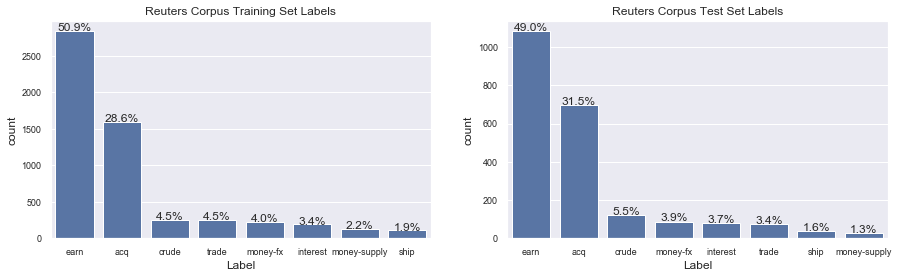

In [70]:
# how many of each class are we dealing with?
train_labels_df = pd.DataFrame({'Label':y_train})
test_labels_df = pd.DataFrame({'Label':y_test})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
sns.set(style="darkgrid")

ax = axes[0]
sns.countplot(x='Label', data=train_labels_df, color=current_palette[0], ax=ax, order=train_labels_df['Label'].value_counts().index).set_title("Reuters Corpus Training Set Labels") 
ax.tick_params(labelsize=9)
total = float(len(y_train))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.1f}%'.format(height/total*100), ha="center")

ax = axes[1]
sns.countplot(x='Label', data=test_labels_df, color=current_palette[0], ax=ax, order=test_labels_df['Label'].value_counts().index).set_title("Reuters Corpus Test Set Labels")
ax.tick_params(labelsize=9)
total = float(len(y_test))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.1f}%'.format(height/total*100), ha="center")


In [86]:
# snapshot for before
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))

Counter({'earn': 2840, 'acq': 1596, 'crude': 253, 'trade': 250, 'money-fx': 222, 'interest': 191, 'money-supply': 123, 'ship': 108})
Counter({'earn': 1083, 'acq': 696, 'crude': 121, 'money-fx': 87, 'interest': 81, 'trade': 76, 'ship': 36, 'money-supply': 28})


In [87]:
category_clean = {"acq": 0, "crude": 1, "earn": 2, "interest": 3, "money-fx": 4, "money-supply": 5, "ship": 6, "trade": 7}
y_train = [category_clean[i] for i in y_train]
y_test = [category_clean[i] for i in y_test]

In [88]:
# after - looks good
print(Counter(y_train))
print(Counter(y_test))

Counter({2: 2840, 0: 1596, 1: 253, 7: 250, 4: 222, 3: 191, 5: 123, 6: 108})
Counter({2: 1083, 0: 696, 1: 121, 4: 87, 3: 81, 7: 76, 6: 36, 5: 28})


In [89]:
# now we need to turn our attention to encoding the text data in both data sets
# we will split training set into train & validation sets once the data is all clean
# we test this out before applying this to all the training and test data
from keras.preprocessing.text import Tokenizer
samples = [X_train[0], X_train[1]]

tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples,mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 161 unique tokens.


In [14]:
print(samples)
print(sequences)
print(one_hot_results)
print(word_index)

["COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES SALE\n  Computer Terminal Systems Inc said\n  it has completed the sale of 200,000 shares of its common\n  stock, and warrants to acquire an additional one mln shares, to\n  &lt;Sedio N.V.> of Lugano, Switzerland for 50,000 dlrs.\n      The company said the warrants are exercisable for five\n  years at a purchase price of .125 dlrs per share.\n      Computer Terminal said Sedio also has the right to buy\n  additional shares and increase its total holdings up to 40 pct\n  of the Computer Terminal's outstanding common stock under\n  certain circumstances involving change of control at the\n  company.\n      The company said if the conditions occur the warrants would\n  be exercisable at a price equal to 75 pct of its common stock's\n  market price at the time, not to exceed 1.50 dlrs per share.\n      Computer Terminal also said it sold the technolgy rights to\n  its Dot Matrix impact technology, including any future\n  improvements, to &lt

In [73]:
# we could train using all the text data from every article, but the goal is to build a good model without using all the data
# let's try to determine the max len to use
from numpy import percentile
X_len =[]
for i in range(len(X_train)):
    X_len.append(len(X_train[i]))

# 5-number summary
print("Min", min(X_len))
print("Quartiles", percentile(X_len, [25, 50, 75]))
print("Max", max(X_len))
# could limit to top 300-400 or something

Min 27
Quartiles [241. 458. 782.]
Max 5901


In [16]:
# let's get a sample sentence
print(len(X_train[0]))
print(X_train[0])

1389
COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES SALE
  Computer Terminal Systems Inc said
  it has completed the sale of 200,000 shares of its common
  stock, and warrants to acquire an additional one mln shares, to
  &lt;Sedio N.V.> of Lugano, Switzerland for 50,000 dlrs.
      The company said the warrants are exercisable for five
  years at a purchase price of .125 dlrs per share.
      Computer Terminal said Sedio also has the right to buy
  additional shares and increase its total holdings up to 40 pct
  of the Computer Terminal's outstanding common stock under
  certain circumstances involving change of control at the
  company.
      The company said if the conditions occur the warrants would
  be exercisable at a price equal to 75 pct of its common stock's
  market price at the time, not to exceed 1.50 dlrs per share.
      Computer Terminal also said it sold the technolgy rights to
  its Dot Matrix impact technology, including any future
  improvements, to &lt;Woodco Inc> o

In [90]:
# now let's tokenize the data
# and split training data into training & validation sets
# Chollet p. 189-190
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 300 # cuts off articles after 300 words
max_words = 10000 # considers only the top 10000 words in the dataset
validation_samples = 2233 # 60/40 split
training_samples = len(X_train) - validation_samples

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(y_train)
print('Shape of data tensor: ', data.shape)
print('Shape of label tensor: ', labels.shape)

X_train = data[:training_samples]
y_train = labels[:training_samples]
X_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape: ', X_val.shape)
print('y_val shape: ', y_val.shape)

Found 22358 unique tokens.
Shape of data tensor:  (5583, 300)
Shape of label tensor:  (5583,)
X_train shape:  (3350, 300)
y_train shape:  (3350,)
X_val shape:  (2233, 300)
y_val shape:  (2233,)


In [91]:
# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
# inspect distribution of labels
c = Counter(y_train)
a = [(i, c[i] / len(y_train) * 100.0) for i in c]
c = Counter(y_val)
b = [(i, c[i] / len(y_val) * 100.0) for i in c]
c = Counter(y_test)
d = [(i, c[i] / len(y_test) * 100.0) for i in c]
print(a)
print(b)
print(d)

[(0, 29.134328358208954), (5, 2.3880597014925375), (2, 48.11940298507463), (4, 4.059701492537314), (1, 5.164179104477612), (3, 4.447761194029851), (7, 4.417910447761194), (6, 2.268656716417911)]
[(2, 54.993282579489474), (0, 27.765338110165693), (6, 1.4330497089117777), (4, 3.851321092700403), (7, 4.567845947156292), (1, 3.5826242722794444), (5, 1.9256605463502015), (3, 1.8808777429467085)]
[(7, 3.4420289855072466), (6, 1.6304347826086956), (0, 31.521739130434785), (2, 49.04891304347826), (4, 3.940217391304348), (3, 3.6684782608695654), (1, 5.480072463768116), (5, 1.2681159420289856)]


In [92]:
# indexing is ordered after the most common words in the text (index 1)
# zero index is used for padding
print(sequences[0])
print(X_train[0]) # can see the padding
print(np.unique(y_train)) # 8 unique vals from 0-7

[525, 2407, 309, 12, 790, 114, 525, 2407, 309, 30, 6, 13, 37, 369, 1, 114, 2, 477, 15, 51, 2, 18, 113, 60, 7, 1085, 3, 236, 48, 533, 62, 8, 51, 3, 12, 456, 2269, 2, 2803, 11, 116, 15, 10, 1, 33, 6, 1, 1085, 76, 2933, 11, 126, 274, 34, 5, 258, 151, 2, 1075, 10, 87, 42, 525, 2407, 6, 70, 37, 1, 674, 3, 170, 533, 51, 7, 184, 18, 165, 401, 92, 3, 255, 21, 2, 1, 525, 219, 113, 60, 168, 481, 2023, 2485, 478, 2, 358, 34, 1, 33, 1, 33, 6, 139, 1, 619, 2804, 1, 1085, 49, 32, 2933, 34, 5, 151, 1434, 3, 381, 21, 2, 18, 113, 89, 151, 34, 1, 227, 52, 3, 1462, 16, 116, 10, 87, 42, 525, 2407, 70, 6, 13, 331, 1, 539, 3, 18, 1702, 7821, 863, 638, 365, 217, 430, 2805, 3, 12, 30, 2, 1514, 8967, 11, 477, 15, 10, 65, 13, 6, 13, 49, 390, 3, 32, 1, 4002, 1206, 4950, 2, 1, 638, 11, 1, 33, 6, 1, 1238, 78, 330, 2, 18, 1810, 296, 7, 49, 434, 127, 183, 827, 382, 7, 2195, 779, 1737, 525, 2407, 834, 525, 3764, 7822, 3061, 7, 5817, 7001, 7, 4951]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0

In [93]:
# one hot encoding transformation to work with RNNs
# needed b/c we are working with a multiclassification problem
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

In [94]:
# verifying we have 8 classes in the transformation
print(y_train_one_hot.shape)
print(y_val_one_hot.shape)
print(y_test_one_hot.shape)

(3350, 8)
(2233, 8)
(2208, 8)


In [21]:
# because classes are imbalanced, we need to adjust for that during training
# we utilize cost-sensitive training instead of upsampling/downsampling
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print(class_weights)

[0.42904713 2.42052023 0.25977047 2.81040268 3.07904412 5.234375
 5.50986842 2.82939189]


# Methods

In [22]:
# global model params
n_outputs = 8 # 8 different classes
n_batch_size = 32
num_epochs = 10
max_words = 10000 # redefining here, just to make sure
max_len = 300

In [ ]:
# change directory to model folder so we can save models
os.chdir(model_path)

In [58]:
# dense models
def dense_base_f():
    model = Sequential()
    #model.add(Flatten(input_shape=(max_len, X_train.shape[-1])))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])
    return model

def dense_multiple_layers_f():
    model = Sequential()
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])
    return model

# RNN models
# simpleRNN cells
def simple_rnn_f():
    model = Sequential()
    model.add(Embedding(max_words, 32, input_length=maxlen))
    model.add(SimpleRNN(32))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])
    return model

def simple_rnn2_f():
    model = Sequential()
    model.add(Embedding(max_words, 32, input_length=maxlen))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])
    return model

# without LSTM
def rnn_base_no_lstm_f():
    model = Sequential()
    model.add(Embedding(max_words, 32, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])
    return model

# with LSTM
def rnn_base_f():
    model = Sequential()
    model.add(Embedding(max_words, 32, input_length=maxlen))
    model.add(LSTM(32))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])
    return model

def rnn_multiple2_f(node_size1, node_size2):
    model = Sequential()
    model.add(Embedding(max_words, node_size1, input_length=maxlen))
    model.add(LSTM(node_size1, return_sequences=True))
    model.add(LSTM(node_size2))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])
    return model

def rnn_multiple3_f(node_size1, node_size2, node_size3):
    model = Sequential()
    model.add(Embedding(max_words, node_size1, input_length=maxlen))
    model.add(LSTM(node_size1, return_sequences=True))
    model.add(LSTM(node_size2, return_sequences=True))
    model.add(LSTM(node_size3))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])
    return model

# add dropout
def rnn_multiple2_dropout_f(node_size1, node_size2):
    model = Sequential()
    model.add(Embedding(max_words, node_size1, input_length=maxlen))
    model.add(LSTM(node_size1, return_sequences=True, dropout=.2, recurrent_dropout=.2))
    model.add(LSTM(node_size2, dropout=.2, recurrent_dropout=.2))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])
    return model

def rnn_multiple3_dropout_f(node_size1, node_size2, node_size3):
    model = Sequential()
    model.add(Embedding(max_words, node_size1, input_length=maxlen))
    model.add(LSTM(node_size1, return_sequences=True, dropout=.2, recurrent_dropout=.2))
    model.add(LSTM(node_size2, return_sequences=True, dropout=.2, recurrent_dropout=.2))
    model.add(LSTM(node_size3, dropout=.2, recurrent_dropout=.2))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])
    return model

In [24]:
# function definitions to help with training runs
# plot the training and validation loss
def loss_plot(history, model_name):
    # define the values for the plot
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    # now plot these values
    plt.plot(epochs, loss, color=current_palette[0], label='Training loss')
    plt.plot(epochs, val_loss, color=current_palette[1], label='Validation loss')
    plt.title('Training and validation loss ' + str(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
# plot the training and validation accuracy
def acc_plot(history, model_name):
    # define the values for the plot
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1,len(acc)+1)
    # now plot these values
    plt.plot(epochs, acc, color=current_palette[0], label = 'Training acc')
    plt.plot(epochs, val_acc, color=current_palette[1], label='Validation acc')
    plt.title('Training and validation accuracy ' + str(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
def rnn_model_generation(model, model_name):
    #reset_graph() # keep results consistent
    # builds the model that was defined above
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = model
    # add a class weights argument b/c training data is imbalanced
    history = model.fit(X_train, y_train_one_hot, batch_size=n_batch_size, epochs=num_epochs, validation_data = (X_val, y_val_one_hot), class_weight=class_weights, verbose=0)
    model.save(str(model_name+'.h5'))
    summary = model.summary()
    weights = model.get_weights()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
    plt.figure(1)
    plt.subplot(121)
    loss_plot(history, model_name)
    plt.subplot(122)
    acc_plot(history, model_name)
    plt.show()
    return summary, weights, history

In [465]:
# using this to clear space since running this all locally
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                9632      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 9,896
Trainable params: 9,896
Non-trainable params: 0
_________________________________________________________________


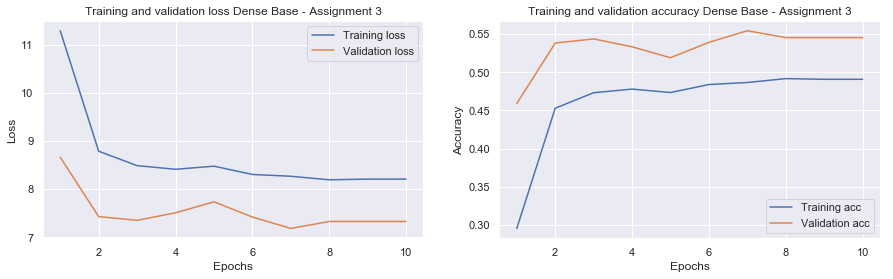

In [466]:
dense_base_start_time = time.time()
dense_base = rnn_model_generation(dense_base_f(), "Dense Base - Assignment 3")
dense_base_elapsed_time = time.time() - dense_base_start_time

In [409]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
Total params: 5,624
Trainable params: 5,624
Non-trainable params: 0
_________________________________________________________________


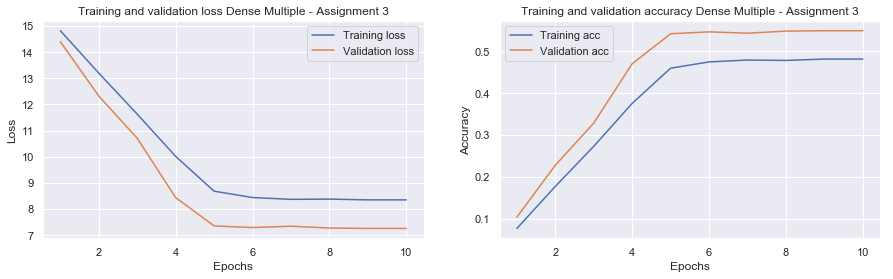

In [467]:
# no matter which combinations i try, can't improve accuracy
# underfitting is an issue and see bigger gap in training/validation sets as model complexity increases
dense_multiple_start_time = time.time()
dense_multiple = rnn_model_generation(dense_multiple_layers_f(), "Dense Multiple - Assignment 3")
dense_multiple_elapsed_time = time.time() - dense_multiple_start_time

In [468]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 322,344
Trainable params: 322,344
Non-trainable params: 0
_________________________________________________________________


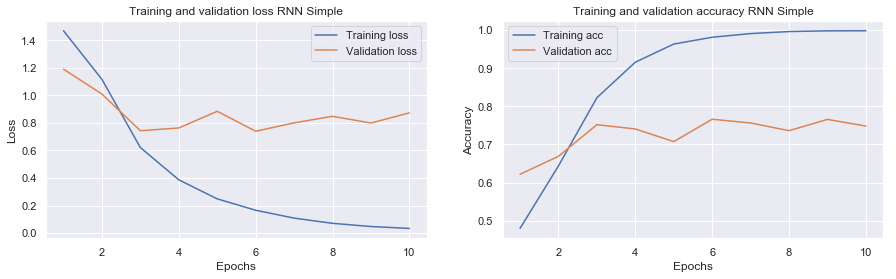

In [469]:
rnn_simple_start_time = time.time()
rnn_simple = rnn_model_generation(simple_rnn_f(), "RNN Simple")
rnn_simple_elapsed_time = time.time() - rnn_simple_start_time

In [470]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 300, 32)           2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 300, 32)           2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 326,504
Trainable params: 326,504
Non-trainable params: 0
_________________________________________________________________


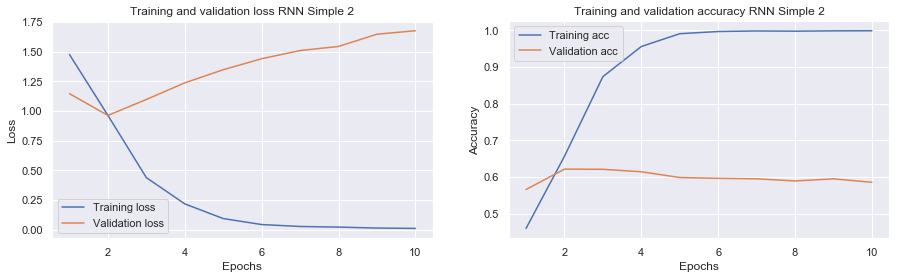

In [471]:
rnn_simple_start_time2 = time.time()
rnn_simple2 = rnn_model_generation(simple_rnn2_f(), "RNN Simple 2")
rnn_simple_elapsed_time2 = time.time() - rnn_simple_start_time2

In [472]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 328,584
Trainable params: 328,584
Non-trainable params: 0
_________________________________________________________________


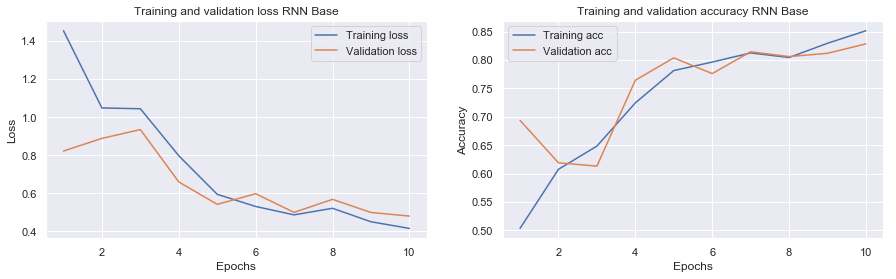

In [473]:
rnn_base_start_time = time.time()
rnn_base = rnn_model_generation(rnn_base_f(), "RNN Base")
rnn_base_elapsed_time = time.time() - rnn_base_start_time

In [485]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 32)           8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 336,904
Trainable params: 336,904
Non-trainable params: 0
_________________________________________________________________


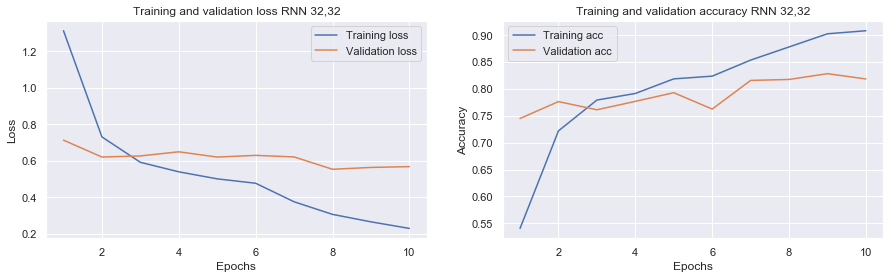

In [487]:
rnn_multiple_start_time_32_32 = time.time()
rnn_multiple_32_32 = rnn_model_generation(rnn_multiple2_f(32,32), "RNN 32,32")
rnn_multiple_elapsed_time_32_32 = time.time() - rnn_multiple_start_time_32_32

In [488]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 32)           8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 353,672
Trainable params: 353,672
Non-trainable params: 0
_________________________________________________________________


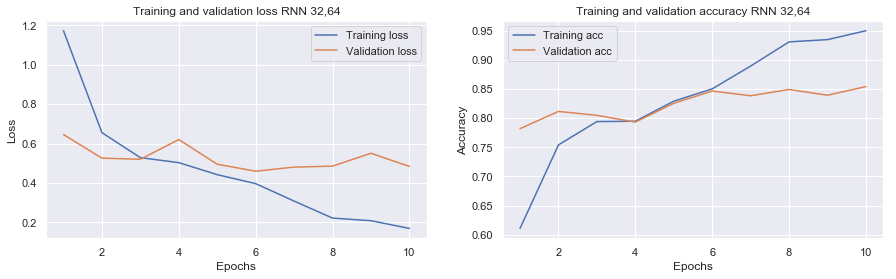

In [489]:
rnn_multiple_start_time_32_64 = time.time()
rnn_multiple_32_64 = rnn_model_generation(rnn_multiple2_f(32,64), "RNN 32,64")
rnn_multiple_elapsed_time_32_64 = time.time() - rnn_multiple_start_time_32_64

In [490]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 32)           8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 32)           8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 345,224
Trainable params: 345,224
Non-trainable params: 0
_________________________________________________________________


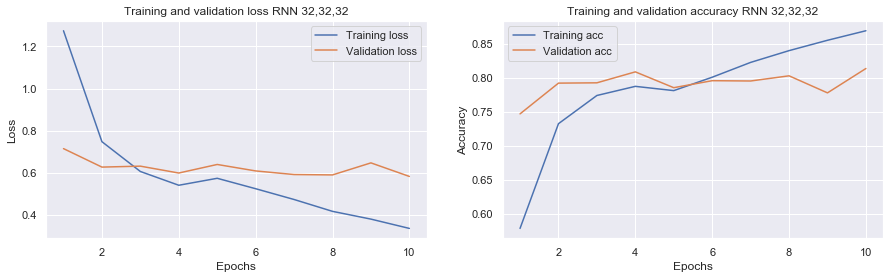

In [491]:
rnn_multiple_start_time_32_32_32 = time.time()
rnn_multiple_32_32_32 = rnn_model_generation(rnn_multiple3_f(32,32,32), "RNN 32,32,32")
rnn_multiple_elapsed_time_32_32_32 = time.time() - rnn_multiple_start_time_32_32_32

In [492]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 32)           8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 64)           24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 453,000
Trainable params: 453,000
Non-trainable params: 0
_________________________________________________________________


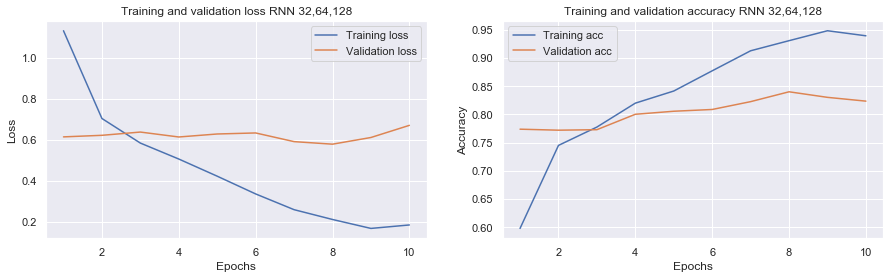

In [493]:
rnn_multiple_start_time_32_64_128 = time.time()
rnn_multiple_32_64_128 = rnn_model_generation(rnn_multiple3_f(32,64,128), "RNN 32,64,128")
rnn_multiple_elapsed_time_32_64_128 = time.time() - rnn_multiple_start_time_32_64_128

In [494]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 9600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 76808     
Total params: 396,808
Trainable params: 396,808
Non-trainable params: 0
_________________________________________________________________


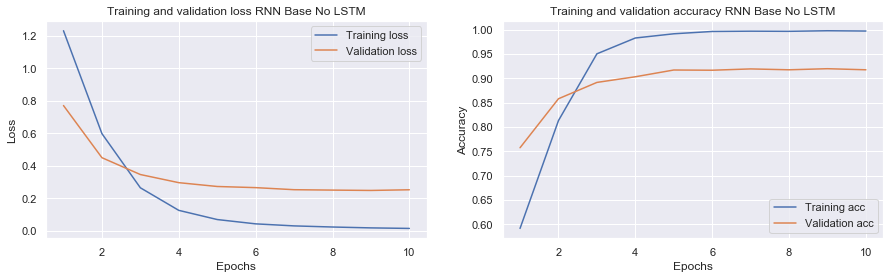

In [478]:
rnn_base_no_lstm_start_time = time.time()
rnn_base_no_lstm = rnn_model_generation(rnn_base_no_lstm_f(), "RNN Base No LSTM")
rnn_base_no_lstm_elapsed_time = time.time() - rnn_base_no_lstm_start_time

In [46]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 32)           8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 336,904
Trainable params: 336,904
Non-trainable params: 0
_________________________________________________________________


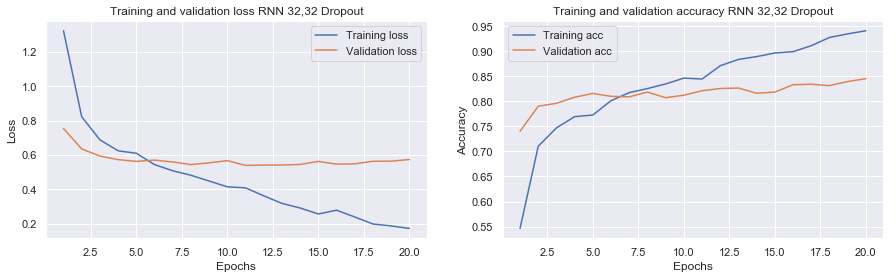

In [52]:
# retrain adding dropout
# double the number of epochs b/c convergence takes longer
num_epochs = 20
rnn_multiple_start_time_32_32_dropout = time.time()
rnn_multiple_32_32_dropout = rnn_model_generation(rnn_multiple2_dropout_f(32,32), "RNN 32,32 Dropout")
rnn_multiple_elapsed_time_32_32_dropout = time.time() - rnn_multiple_start_time_32_32_dropout

In [56]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 32)           8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 32)           8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 345,224
Trainable params: 345,224
Non-trainable params: 0
_________________________________________________________________


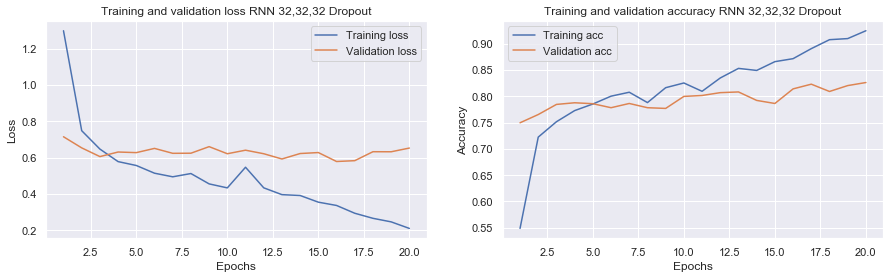

In [59]:
rnn_multiple_start_time_32_32_32_dropout = time.time()
rnn_multiple_32_32_32_dropout = rnn_model_generation(rnn_multiple3_dropout_f(32,32,32), "RNN 32,32,32 Dropout")
rnn_multiple_elapsed_time_32_32_32_dropout = time.time() - rnn_multiple_start_time_32_32_32_dropout

In [495]:
# generate table to summarize results
dense1_acc = '{:.1%}'.format(np.mean(dense_base[2].history['acc']))
dense1_val_acc = '{:.1%}'.format(np.mean(dense_base[2].history['val_acc']))
dense2_acc = '{:.1%}'.format(np.mean(dense_multiple[2].history['acc']))
dense2_val_acc = '{:.1%}'.format(np.mean(dense_multiple[2].history['val_acc']))
rnn_simple_acc = '{:.1%}'.format(np.mean(rnn_simple[2].history['acc']))
rnn_simple_val_acc = '{:.1%}'.format(np.mean(rnn_simple[2].history['val_acc']))
rnn_simple2_acc = '{:.1%}'.format(np.mean(rnn_simple2[2].history['acc']))
rnn_simple2_val_acc = '{:.1%}'.format(np.mean(rnn_simple2[2].history['val_acc']))
rnn_base_acc = '{:.1%}'.format(np.mean(rnn_base[2].history['acc']))
rnn_base_val_acc = '{:.1%}'.format(np.mean(rnn_base[2].history['val_acc']))
rnn_base_no_lstm_acc = '{:.1%}'.format(np.mean(rnn_base_no_lstm[2].history['acc']))
rnn_base_no_lstm_val_acc = '{:.1%}'.format(np.mean(rnn_base_no_lstm[2].history['val_acc']))
rnn_multiple32_32_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_32[2].history['acc']))
rnn_multiple32_32_val_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_32[2].history['val_acc']))
rnn_multiple32_64_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_64[2].history['acc']))
rnn_multiple32_64_val_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_64[2].history['val_acc']))
rnn_multiple32_32_32_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_32_32[2].history['acc']))
rnn_multiple32_32_32_val_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_32_32[2].history['val_acc']))
rnn_multiple32_64_128_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_64_128[2].history['acc']))
rnn_multiple32_64_128_val_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_64_128[2].history['val_acc']))


a = PrettyTable()
a.field_names = ['Model', 'Layers/Nodes', 'Train Accuracy', 'Val Accuracy', 'Processing Time']
a.add_row(['Dense Base', '32', dense1_acc, dense1_val_acc, round(dense_base_elapsed_time,1)])
a.add_row(['Dense Multiple', '16,32', dense2_acc, dense2_val_acc, round(dense_multiple_elapsed_time,1)])
a.add_row(['RNN Base LSTM', '32', rnn_base_acc, rnn_base_val_acc, round(rnn_base_elapsed_time,1)])
a.add_row(['RNN Base No LSTM', '32', rnn_base_no_lstm_acc, rnn_base_no_lstm_val_acc, round(rnn_base_no_lstm_elapsed_time,1)])
a.add_row(['RNN Flat Simple', '32', rnn_simple_acc, rnn_simple_val_acc, round(rnn_simple_elapsed_time,1)])
a.add_row(['RNN Flat Simple', '32,32,32', rnn_simple2_acc, rnn_simple2_val_acc, round(rnn_simple_elapsed_time2,1)])
a.add_row(['RNN Flat LSTM', '32,32', rnn_multiple32_32_acc, rnn_multiple32_32_val_acc, round(rnn_multiple_elapsed_time_32_32,1)])
a.add_row(['RNN Pyramid LSTM', '32,64', rnn_multiple32_64_acc, rnn_multiple32_64_val_acc, round(rnn_multiple_elapsed_time_32_64,1)])
a.add_row(['RNN Flat LSTM', '32,32,32', rnn_multiple32_32_32_acc, rnn_multiple32_32_32_val_acc, round(rnn_multiple_elapsed_time_32_32_32,1)])
a.add_row(['RNN Pyramid LSTM', '32,64,128', rnn_multiple32_64_128_acc, rnn_multiple32_64_128_val_acc, round(rnn_multiple_elapsed_time_32_64_128,1)])
print(a.get_string(title="Training Results"))

+-----------------------------------------------------------------------------------+
|                                  Training Results                                 |
+------------------+--------------+----------------+--------------+-----------------+
|      Model       | Layers/Nodes | Train Accuracy | Val Accuracy | Processing Time |
+------------------+--------------+----------------+--------------+-----------------+
|    Dense Base    |      32      |     46.2%      |    53.2%     |       3.3       |
|  Dense Multiple  |    16,32     |     37.6%      |    44.1%     |       3.7       |
|  RNN Base LSTM   |      32      |     73.6%      |    75.3%     |      561.6      |
| RNN Base No LSTM |      32      |     93.1%      |    89.2%     |       13.9      |
| RNN Flat Simple  |      32      |     87.9%      |    72.6%     |      120.8      |
| RNN Flat Simple  |   32,32,32   |     89.3%      |    59.8%     |      2694.3     |
|  RNN Flat LSTM   |    32,32     |     80.2%      |  

In [60]:
# adding table for dropout models
# these were added later and thus are separate from above
rnn_multiple32_32_dropout_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_32_dropout[2].history['acc']))
rnn_multiple32_32_dropout_val_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_32_dropout[2].history['val_acc']))
rnn_multiple32_32_32_dropout_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_32_32_dropout[2].history['acc']))
rnn_multiple32_32_32_dropout_val_acc = '{:.1%}'.format(np.mean(rnn_multiple_32_32_32_dropout[2].history['val_acc']))

a = PrettyTable()
a.field_names = ['Model', 'Layers/Nodes', 'Train Accuracy', 'Val Accuracy', 'Processing Time']
a.add_row(['RNN Flat LSTM', '32,32 w/ dropout', rnn_multiple32_32_dropout_acc, rnn_multiple32_32_dropout_val_acc, round(rnn_multiple_elapsed_time_32_32_dropout,1)])
a.add_row(['RNN Flat LSTM', '32,32,32 w/ dropout', rnn_multiple32_32_32_dropout_acc, rnn_multiple32_32_32_dropout_val_acc, round(rnn_multiple_elapsed_time_32_32_32_dropout,1)])
print(a.get_string(title="Training Results - Dropout Models"))

+---------------------------------------------------------------------------------------+
|                           Training Results - Dropout Models                           |
+---------------+---------------------+----------------+--------------+-----------------+
|     Model     |     Layers/Nodes    | Train Accuracy | Val Accuracy | Processing Time |
+---------------+---------------------+----------------+--------------+-----------------+
| RNN Flat LSTM |   32,32 w/ dropout  |     83.4%      |    81.5%     |      1830.5     |
| RNN Flat LSTM | 32,32,32 w/ dropout |     81.7%      |    79.4%     |      2779.9     |
+---------------+---------------------+----------------+--------------+-----------------+


# Results

In [37]:
# need to prepare the test data
# originally, this is what was performed
# Chollet p. 189-190
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 300 # cuts off articles after 300 words
max_words = 10000 # considers only the top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_test)
sequences = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

print('Shape of data tensor: ', data.shape)

X_test = data[:]

print('X_test shape: ', X_test.shape)

Found 13763 unique tokens.
Shape of data tensor:  (2208, 300)
X_test shape:  (2208, 300)


In [32]:
# mention that if more time allowed would increase the # of epochs on training set and then refit them to test set
# define functions to fit data to test set
def rnn_model_evaluation(model_name):
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = load_model(model_name)
    results = model.evaluate(X_test, y_test_one_hot)
    predictions = model.predict(X_test)
    return results, predictions

In [61]:
# run all models on test set
dense_base_results = rnn_model_evaluation('Dense Base - Assignment 3.h5')
dense_multiple_results = rnn_model_evaluation('Dense Multiple - Assignment 3.h5')
rnn_base_results = rnn_model_evaluation('RNN Base.h5')
rnn_base_no_lstm_results = rnn_model_evaluation('RNN Base No LSTM.h5')
rnn_simple_results = rnn_model_evaluation('RNN Simple.h5')
rnn_simple2_results = rnn_model_evaluation('RNN Simple 2.h5')
rnn_multiple_32_32_results = rnn_model_evaluation('RNN 32,32.h5') 
rnn_multiple_32_64_results = rnn_model_evaluation('RNN 32,64.h5')
rnn_multiple_32_32_32_results = rnn_model_evaluation('RNN 32,32,32.h5')
rnn_multiple_32_64_128_results = rnn_model_evaluation('RNN 32,64,128.h5')
rnn_multiple_32_32_dropout_results = rnn_model_evaluation('RNN 32,32 Dropout.h5')
rnn_multiple_32_32_32_dropout_results = rnn_model_evaluation('RNN 32,32,32 Dropout.h5')

2208/2208 [==============================] - 13s 6ms/step


In [62]:
# generate a summary table
dense_base_acc = '{:.1%}'.format(dense_base_results[0][1])
dense_multiple_acc = '{:.1%}'.format(dense_multiple_results[0][1])
rnn_base_acc = '{:.1%}'.format(rnn_base_results[0][1])
rnn_base_no_lstm_acc = '{:.1%}'.format(rnn_base_no_lstm_results[0][1])
rnn_simple_acc = '{:.1%}'.format(rnn_simple_results[0][1])
rnn_simple2_acc = '{:.1%}'.format(rnn_simple2_results[0][1])
rnn_multiple_32_32_acc = '{:.1%}'.format(rnn_multiple_32_32_results[0][1])
rnn_multiple_32_64_acc = '{:.1%}'.format(rnn_multiple_32_64_results[0][1])
rnn_multiple_32_32_32_acc = '{:.1%}'.format(rnn_multiple_32_32_32_results[0][1])
rnn_multiple_32_64_128_acc = '{:.1%}'.format(rnn_multiple_32_64_128_results[0][1])
rnn_multiple_32_32_dropout_acc = '{:.1%}'.format(rnn_multiple_32_32_dropout_results[0][1])
rnn_multiple_32_32_32_dropout_acc = '{:.1%}'.format(rnn_multiple_32_32_32_dropout_results[0][1])

a = PrettyTable()
a.field_names = ['Model', 'Layers/Nodes', 'Accuracy']
a.add_row(['Dense Base', '32', dense_base_acc])
a.add_row(['Dense Multiple', '16,32', dense_multiple_acc])
a.add_row(['RNN Base LSTM', '32', rnn_base_acc])
a.add_row(['RNN Base No LSTM', '32', rnn_base_no_lstm_acc])
a.add_row(['RNN Flat Simple', '32', rnn_simple_acc])
a.add_row(['RNN Flat Simple', '32,32,32', rnn_simple2_acc])
a.add_row(['RNN Flat LSTM', '32,32', rnn_multiple_32_32_acc])
a.add_row(['RNN Pyramid LSTM', '32,64', rnn_multiple_32_64_acc])
a.add_row(['RNN Flat LSTM', '32,32,32', rnn_multiple_32_32_32_acc])
a.add_row(['RNN Pyramid LSTM', '32,64,128', rnn_multiple_32_64_128_acc])
a.add_row(['RNN Flat LSTM', '32,32 w/ dropout', rnn_multiple_32_32_dropout_acc])
a.add_row(['RNN Flat LSTM', '32,32,32 w/ dropout', rnn_multiple_32_32_32_dropout_acc])
print(a.get_string(title="Test Set Results"))

+---------------------------------------------------+
|                  Test Set Results                 |
+------------------+---------------------+----------+
|      Model       |     Layers/Nodes    | Accuracy |
+------------------+---------------------+----------+
|    Dense Base    |          32         |  51.1%   |
|  Dense Multiple  |        16,32        |  48.7%   |
|  RNN Base LSTM   |          32         |  40.5%   |
| RNN Base No LSTM |          32         |  44.9%   |
| RNN Flat Simple  |          32         |  39.5%   |
| RNN Flat Simple  |       32,32,32      |  41.3%   |
|  RNN Flat LSTM   |        32,32        |  36.6%   |
| RNN Pyramid LSTM |        32,64        |  37.7%   |
|  RNN Flat LSTM   |       32,32,32      |  35.9%   |
| RNN Pyramid LSTM |      32,64,128      |  32.9%   |
|  RNN Flat LSTM   |   32,32 w/ dropout  |  31.0%   |
|  RNN Flat LSTM   | 32,32,32 w/ dropout |  37.5%   |
+------------------+---------------------+----------+


In [95]:
# test set results are terrible b/c the test set has a different tokenizer than the training data
# therefore, need to tokenize the test data in the same way that was used on the training data

# load the previous tokenizer - this was stored in different folder
os.chdir('..\\code')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [96]:
tokenizer.fit_on_texts(X_test)
sequences = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

print('Shape of data tensor: ', data.shape)

X_test = data[:]

print('X_test shape: ', X_test.shape)

Found 26358 unique tokens.
Shape of data tensor:  (2208, 300)
X_test shape:  (2208, 300)


In [97]:
def rnn_model_evaluation(model_name):
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = load_model(model_name)
    results = model.evaluate(X_test, y_test_one_hot)
    predictions = model.predict(X_test)
    return results, predictions

In [98]:
# run all models on test set
dense_base_results = rnn_model_evaluation('Dense Base - Assignment 3.h5')
dense_multiple_results = rnn_model_evaluation('Dense Multiple - Assignment 3.h5')
rnn_base_results = rnn_model_evaluation('RNN Base.h5')
rnn_base_no_lstm_results = rnn_model_evaluation('RNN Base No LSTM.h5')
rnn_simple_results = rnn_model_evaluation('RNN Simple.h5')
rnn_simple2_results = rnn_model_evaluation('RNN Simple 2.h5')
rnn_multiple_32_32_results = rnn_model_evaluation('RNN 32,32.h5') 
rnn_multiple_32_64_results = rnn_model_evaluation('RNN 32,64.h5')
rnn_multiple_32_32_32_results = rnn_model_evaluation('RNN 32,32,32.h5')
rnn_multiple_32_64_128_results = rnn_model_evaluation('RNN 32,64,128.h5')
rnn_multiple_32_32_dropout_results = rnn_model_evaluation('RNN 32,32 Dropout.h5')
rnn_multiple_32_32_32_dropout_results = rnn_model_evaluation('RNN 32,32,32 Dropout.h5')

2208/2208 [==============================] - 16s 7ms/step


In [99]:
# generate a summary table
dense_base_acc = '{:.1%}'.format(dense_base_results[0][1])
dense_multiple_acc = '{:.1%}'.format(dense_multiple_results[0][1])
rnn_base_acc = '{:.1%}'.format(rnn_base_results[0][1])
rnn_base_no_lstm_acc = '{:.1%}'.format(rnn_base_no_lstm_results[0][1])
rnn_simple_acc = '{:.1%}'.format(rnn_simple_results[0][1])
rnn_simple2_acc = '{:.1%}'.format(rnn_simple2_results[0][1])
rnn_multiple_32_32_acc = '{:.1%}'.format(rnn_multiple_32_32_results[0][1])
rnn_multiple_32_64_acc = '{:.1%}'.format(rnn_multiple_32_64_results[0][1])
rnn_multiple_32_32_32_acc = '{:.1%}'.format(rnn_multiple_32_32_32_results[0][1])
rnn_multiple_32_64_128_acc = '{:.1%}'.format(rnn_multiple_32_64_128_results[0][1])
rnn_multiple_32_32_dropout_acc = '{:.1%}'.format(rnn_multiple_32_32_dropout_results[0][1])
rnn_multiple_32_32_32_dropout_acc = '{:.1%}'.format(rnn_multiple_32_32_32_dropout_results[0][1])

a = PrettyTable()
a.field_names = ['Model', 'Layers/Nodes', 'Accuracy']
a.add_row(['Dense Base', '32', dense_base_acc])
a.add_row(['Dense Multiple', '16,32', dense_multiple_acc])
a.add_row(['RNN Base LSTM', '32', rnn_base_acc])
a.add_row(['RNN Base No LSTM', '32', rnn_base_no_lstm_acc])
a.add_row(['RNN Flat Simple', '32', rnn_simple_acc])
a.add_row(['RNN Flat Simple', '32,32,32', rnn_simple2_acc])
a.add_row(['RNN Flat LSTM', '32,32', rnn_multiple_32_32_acc])
a.add_row(['RNN Pyramid LSTM', '32,64', rnn_multiple_32_64_acc])
a.add_row(['RNN Flat LSTM', '32,32,32', rnn_multiple_32_32_32_acc])
a.add_row(['RNN Pyramid LSTM', '32,64,128', rnn_multiple_32_64_128_acc])
a.add_row(['RNN Flat LSTM', '32,32 w/ dropout', rnn_multiple_32_32_dropout_acc])
a.add_row(['RNN Flat LSTM', '32,32,32 w/ dropout', rnn_multiple_32_32_32_dropout_acc])
print(a.get_string(title="Test Set Results"))

+---------------------------------------------------+
|                  Test Set Results                 |
+------------------+---------------------+----------+
|      Model       |     Layers/Nodes    | Accuracy |
+------------------+---------------------+----------+
|    Dense Base    |          32         |  51.3%   |
|  Dense Multiple  |        16,32        |  48.7%   |
|  RNN Base LSTM   |          32         |  61.6%   |
| RNN Base No LSTM |          32         |  62.6%   |
| RNN Flat Simple  |          32         |  59.6%   |
| RNN Flat Simple  |       32,32,32      |  50.1%   |
|  RNN Flat LSTM   |        32,32        |  63.6%   |
| RNN Pyramid LSTM |        32,64        |  62.5%   |
|  RNN Flat LSTM   |       32,32,32      |  62.9%   |
| RNN Pyramid LSTM |      32,64,128      |  62.9%   |
|  RNN Flat LSTM   |   32,32 w/ dropout  |  61.3%   |
|  RNN Flat LSTM   | 32,32,32 w/ dropout |  61.2%   |
+------------------+---------------------+----------+


# Conclusions
Management Problem. Suppose you are asked by your current employer to develop a conversational agent or chatbot to assist customer support representatives. What advice would you give management about such development? What kinds of method and models would be needed?  Would this be a substantial development project? Do you have any ideas about the information infrastructure needed to support conversational agents in a production environment? 

# References
http://kdd.ics.uci.edu/databases/reuters21578/README.txt

https://realpython.com/python-keras-text-classification/#keras-embedding-layer